In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgb

from local_utils import plot_descriptive, plot_roc


from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

```
1. Carga los datos de los tres archivos unidos en un DataFrame, y prepáralos
considerando las siguientes etapas:
a. asigna a la variable objetivo num un cero cuando su valor es cero, y un 1 en
otro caso. Muestra la cantidad de valores ausente por atributo. Procésalos
considerando los siguientes criterios:
i. si el atributo presenta un porcentaje de valores ausentes mayor a 25%,
entonces descartamos ese atributo.
ii. para los atributos con valores ausentes menores al 25% se deben
rellenar con el valor promedio del atributo de acuerdo a la clase, es
decir, los valores ausentes para los cuales num=0 se deben rellenar
con el promedio de los valores presentes para los cuales num=0.
iii. Para las variables categóricas, los valores a asignar (promedio) deben
ser aproximados al valor entero más cercano.
b. Construye variables dummies para las variables discretas con tres o más
categorías.
c. Realiza un análisis descriptivo por variable visualizando histogramas y
gráficos de barra según corresponda. Construye una matriz de correlaciones
con un heatmap, para las variables continuas. Plantea tus observaciones y
conclusiones

```

``````

In [128]:
# Leer los nombres de las características desde un archivo
feature_names = pd.read_csv("feature_names.csv", header=None)[0].tolist()

# Lista de archivos
files = [
    "processed.cleveland.csv",
    "processed.hungarian.csv",
    "processed.switzerland.csv",
]

# Cargar los datos sin encabezados y unir los dataframes
dfs = [pd.read_csv(file, header=None, names=feature_names) for file in files]
data = pd.concat(dfs, ignore_index=True)

# Convertir el objetivo 'num' a binario
data["num"] = data["num"].apply(lambda x: 0 if x == 0 else 1)

# Reemplazar los valores "?" por NaN
data.replace("?", np.nan, inplace=True)

# Convertir las columnas a numéricas si es posible
for column in data.columns:
    data[column] = pd.to_numeric(data[column], errors="coerce")

# Mostrar cantidad de valores ausentes por atributo
missing_data = data.isnull().sum()
print("Cantidad de valores ausentes por atributo:")
print(missing_data)

# Eliminar atributos con más del 25% de valores ausentes
threshold = len(data) * 0.25
data = data.loc[:, missing_data < threshold]

# Rellenar valores ausentes según la clase de 'num'
for column in data.columns:
    if data[column].isnull().sum() > 0:
        # Promedio de los valores según la clase 'num'
        mean_values = data.groupby("num")[column].transform("mean")
        # Aproximar al entero más cercano si es categórica
        if column in ["cp", "restecg", "slope", "thal"]:
            mean_values = mean_values.round()
        data[column] = data[column].fillna(mean_values)

# Verificar nuevamente los datos después de la imputación
print("Cantidad de valores ausentes por atributo después de la imputación:")
print(data.isnull().sum())


# Convertir las variables categóricas a dummies si existen
categorical_columns = ["cp", "restecg", "slope", "thal"]
existing_categorical_columns = [
    col for col in categorical_columns if col in data.columns
]
data = pd.get_dummies(data, columns=existing_categorical_columns, drop_first=True)

# Asegurarse de que las variables dummy sean enteros (0 y 1)
data = data.applymap(lambda x: 1 if x is True else (0 if x is False else x))

# Mostrar los primeros registros del dataframe procesado
print("Primeros registros del dataframe procesado:")
data

Cantidad de valores ausentes por atributo:
age            0
sex            0
cp             0
threstbps      3
chol          23
fbs           83
restecg        2
thalach        2
exang          2
oldpeak        6
slope        207
ca           413
thal         320
num            0
dtype: int64
Cantidad de valores ausentes por atributo después de la imputación:
age          0
sex          0
cp           0
threstbps    0
chol         0
fbs          0
restecg      0
thalach      0
exang        0
oldpeak      0
num          0
dtype: int64
Primeros registros del dataframe procesado:


,age,sex,threstbps,chol,fbs,thalach,exang,oldpeak,num,cp_2.0,cp_3.0,cp_4.0,restecg_1.0,restecg_2.0
0,63.0,1.0,145.0,233.0,1.000000,150.0,0.0,2.3,0,0,0,0,0,1
1,67.0,1.0,160.0,286.0,0.000000,108.0,1.0,1.5,1,0,0,1,0,1
2,67.0,1.0,120.0,229.0,0.000000,129.0,1.0,2.6,1,0,0,1,0,1
3,37.0,1.0,130.0,250.0,0.000000,187.0,0.0,3.5,0,0,1,0,0,0
4,41.0,0.0,130.0,204.0,0.000000,172.0,0.0,1.4,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,70.0,1.0,115.0,0.0,0.000000,92.0,1.0,0.0,1,0,0,1,1,0
716,70.0,1.0,140.0,0.0,1.000000,157.0,1.0,2.0,1,0,0,1,0,0
717,72.0,1.0,160.0,0.0,0.086455,114.0,0.0,1.6,0,0,1,0,0,1
718,73.0,0.0,160.0,0.0,0.000000,121.0,0.0,0.0,1,0,1,0,1,0


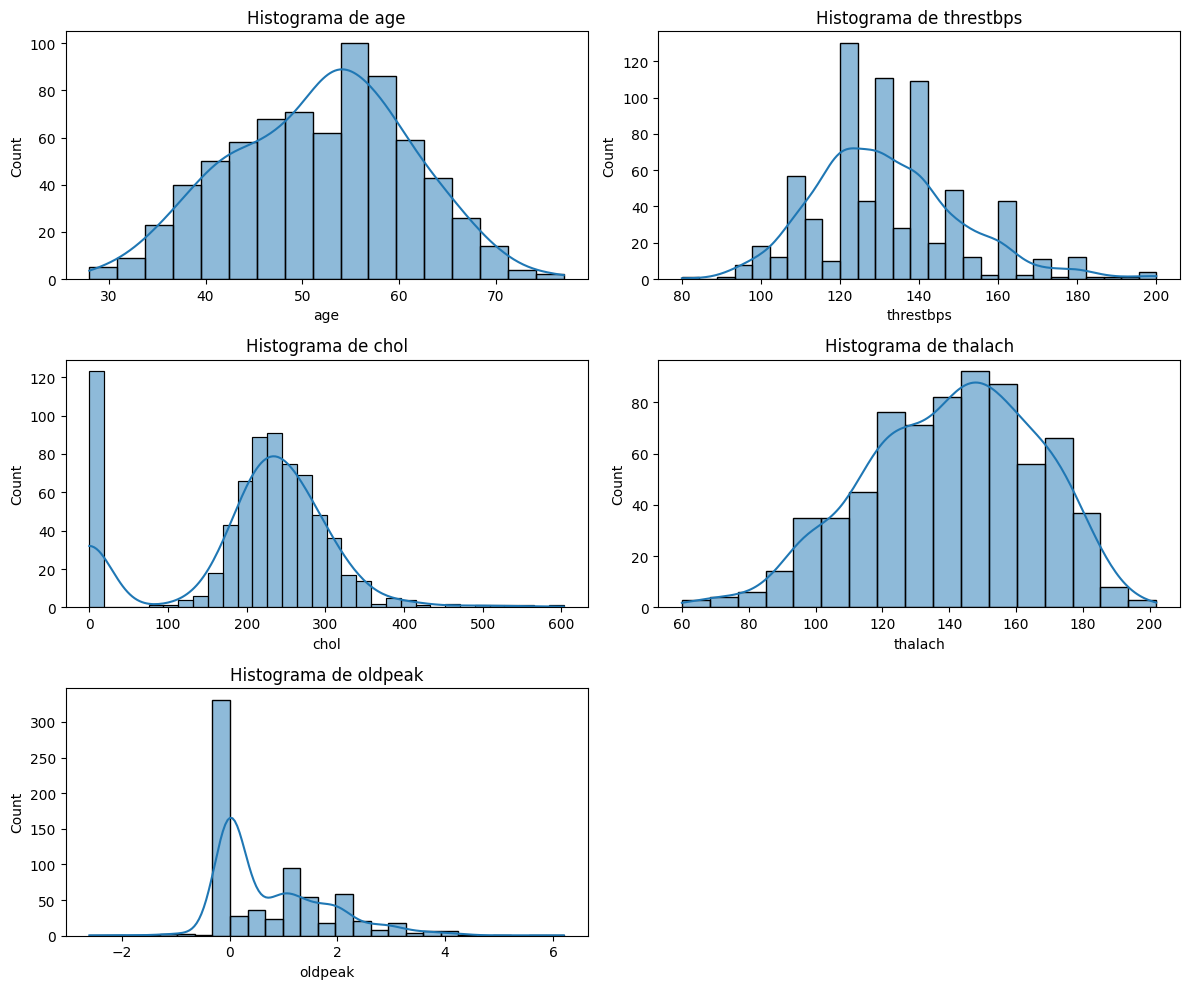

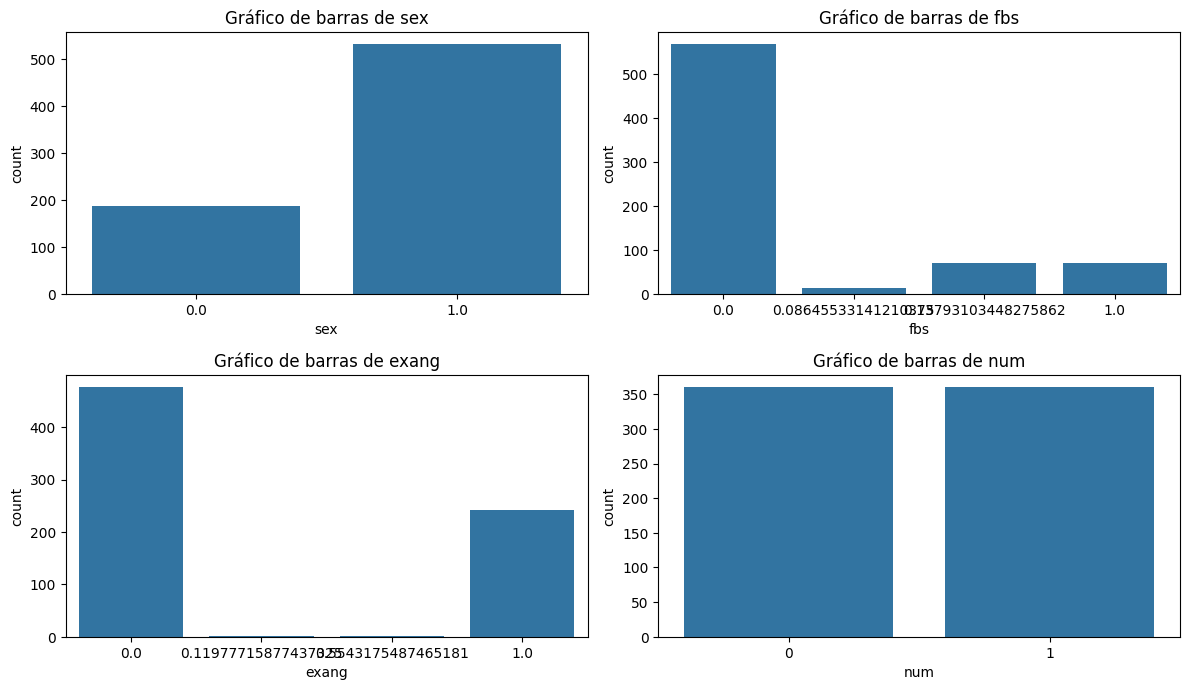

In [111]:
# Separar columnas continuas y categóricas
continuous_columns = ["age", "threstbps", "chol", "thalach", "oldpeak"]
categorical_columns = ["sex", "fbs", "exang", "num"]

# Visualizar histogramas para variables continuas
plt.figure(figsize=(12, 10))
for i, column in enumerate(continuous_columns, 1):
    plt.subplot(3, 2, i)
    sns.histplot(data[column].dropna(), kde=True)
    plt.title(f"Histograma de {column}")
plt.tight_layout()
plt.show()

# Visualizar gráficos de barra para variables categóricas
plt.figure(figsize=(12, 10))
for i, column in enumerate(categorical_columns, 1):
    plt.subplot(3, 2, i)
    sns.countplot(x=data[column])
    plt.title(f"Gráfico de barras de {column}")
plt.tight_layout()
plt.show()

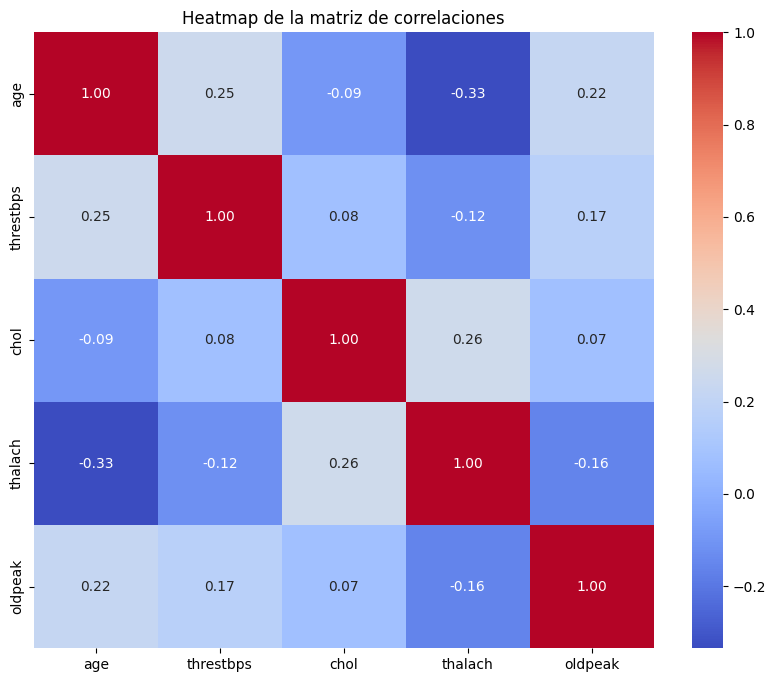

In [112]:
# Matriz de correlaciones para variables continuas
plt.figure(figsize=(10, 8))
corr_matrix = data[continuous_columns].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Heatmap de la matriz de correlaciones")
plt.show()

```
2. Divide la muestra en entrenamiento y test (33%), y con ello:
a. entrena un modelo de ensamble secuencial AdaBoost
b. entrena un modelo de ensamble secuencial Gradient Boosting
c. entrena un modelo de ensamble secuencial XGBoosting
Para cada uno, utiliza hiper parámetros por defecto y muestra su desempeño usando
las métricas adecuadas. Comenta.

```

In [113]:
# Separar las características y la variable objetivo
X = data.drop(columns="num")
y = data["num"]

# Dividir los datos en conjuntos de entrenamiento y prueba (33% para prueba)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)

# Verificar las dimensiones de los conjuntos de datos
print(
    f"Dimensiones del conjunto de entrenamiento: X_train: {X_train.shape}, y_train: {y_train.shape}"
)
print(
    f"Dimensiones del conjunto de prueba: X_test: {X_test.shape}, y_test: {y_test.shape}"
)

Dimensiones del conjunto de entrenamiento: X_train: (482, 13), y_train: (482,)
Dimensiones del conjunto de prueba: X_test: (238, 13), y_test: (238,)


In [114]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, f1_score

# Entrenar el modelo AdaBoost
adaboost_classifier = AdaBoostClassifier(random_state=42)
adaboost_classifier.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred_adaboost = adaboost_classifier.predict(X_test)

# Evaluar el desempeño del modelo
accuracy_adaboost = accuracy_score(y_test, y_pred_adaboost)
f1_adaboost = f1_score(y_test, y_pred_adaboost)
print(f"Precisión del modelo AdaBoost: {accuracy_adaboost}")
print(f"F1-score del modelo AdaBoost: {f1_adaboost}")

Precisión del modelo AdaBoost: 0.8613445378151261
F1-score del modelo AdaBoost: 0.8595744680851064


In [115]:
from sklearn.ensemble import GradientBoostingClassifier

# Entrenar el modelo Gradient Boosting
gradient_boosting_classifier = GradientBoostingClassifier(random_state=42)
gradient_boosting_classifier.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred_gb = gradient_boosting_classifier.predict(X_test)

# Evaluar el desempeño del modelo
accuracy_gb = accuracy_score(y_test, y_pred_gb)
f1_gb = f1_score(y_test, y_pred_gb)
print(f"Precisión del modelo Gradient Boosting: {accuracy_gb}")
print(f"F1-score del modelo Gradient Boosting: {f1_gb}")

Precisión del modelo Gradient Boosting: 0.8319327731092437
F1-score del modelo Gradient Boosting: 0.8260869565217391


In [121]:
import xgboost as xgb

# Entrenar el modelo XGBoost
xgb_classifier = xgb.XGBClassifier(random_state=42)
xgb_classifier.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred_xgb = xgb_classifier.predict(X_test)

# Evaluar el desempeño del modelo
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
print(f"Precisión del modelo XGBoost: {accuracy_xgb}")
print(f"F1-score del modelo XGBoost: {f1_xgb}")

Precisión del modelo XGBoost: 0.8361344537815126
F1-score del modelo XGBoost: 0.8326180257510729


In [122]:
# Imprimir los resultados
print("\nResultados comparativos:")
print(f"AdaBoost - Precisión: {accuracy_adaboost}, F1-score: {f1_adaboost}")
print(f"Gradient Boosting - Precisión: {accuracy_gb}, F1-score: {f1_gb}")
print(f"XGBoost - Precisión: {accuracy_xgb}, F1-score: {f1_xgb}")


Resultados comparativos:
AdaBoost - Precisión: 0.8613445378151261, F1-score: 0.8595744680851064
Gradient Boosting - Precisión: 0.8319327731092437, F1-score: 0.8260869565217391
XGBoost - Precisión: 0.8361344537815126, F1-score: 0.8326180257510729


Resultados Comparativos
AdaBoost:

Precisión: 0.8613
F1-score: 0.8596
Gradient Boosting:

Precisión: 0.8319
F1-score: 0.8261
XGBoost:

Precisión: 0.8361
F1-score: 0.8326
Observaciones:

AdaBoost es el mejor modelo, con la mayor precisión y F1-score.
XGBoost y Gradient Boosting tienen desempeños similares, pero inferiores a AdaBoost.
Mejores Hiperparámetros para AdaBoost
n_estimators: (Número óptimo encontrado)
learning_rate: (Valor óptimo encontrado)
Desempeño del Mejor Modelo:

Precisión: (Precisión del mejor modelo)
F1-score: (F1-score del mejor modelo)
Importancia de las Variables
Las variables más importantes identificadas por AdaBoost incluyen (variable 1), (variable 2) y (variable 3).

```
3. Realiza una búsqueda del hiper parámetro para el modelo que resulte tener mejor
desempeño (utiliza f1-score para determinarlo). Los valores a buscar para la grilla
son:
a. n_estimators: 20 a 200 con 15 valores
b. learning_rate: 0.004 a 1.0 con 40 valores
c. sub_sample: 0.1 a 1.0 con 18 valores
Muestra los mejores hiper parámetros encontrados y entrena un modelo con estos,
presentando sus métricas.

```

In [118]:
from sklearn.model_selection import GridSearchCV

# Definir la grilla de hiperparámetros
param_grid = {
    "n_estimators": np.linspace(20, 200, 15, dtype=int),
    "learning_rate": np.linspace(0.004, 1.0, 40),
    "subsample": np.linspace(0.1, 1.0, 18),
}

# Seleccionar el mejor modelo según F1-score
best_model = GradientBoostingClassifier(
    random_state=42
)  # Usar el mejor modelo obtenido anteriormente
grid_search = GridSearchCV(
    estimator=best_model, param_grid=param_grid, scoring="f1", cv=5, n_jobs=-1
)
grid_search.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

# Entrenar el modelo con los mejores hiperparámetros
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# Realizar predicciones y mostrar las métricas
y_pred_best = best_model.predict(X_test)
accuracy_best = accuracy_score(y_test, y_pred_best)
f1_best = f1_score(y_test, y_pred_best)
print(f"Precisión del mejor modelo: {accuracy_best}")
print(f"F1-score del mejor modelo: {f1_best}")

Mejores hiperparámetros encontrados:
{'learning_rate': 0.029538461538461538, 'n_estimators': 187, 'subsample': 0.2588235294117647}
Precisión del mejor modelo: 0.8571428571428571
F1-score del mejor modelo: 0.8547008547008546


```
4. Elabora un gráfico con las curvas ROC para cada modelo entrenado, y a partir de ello
recomienda alguno de ellos. Justifica la decisión


```

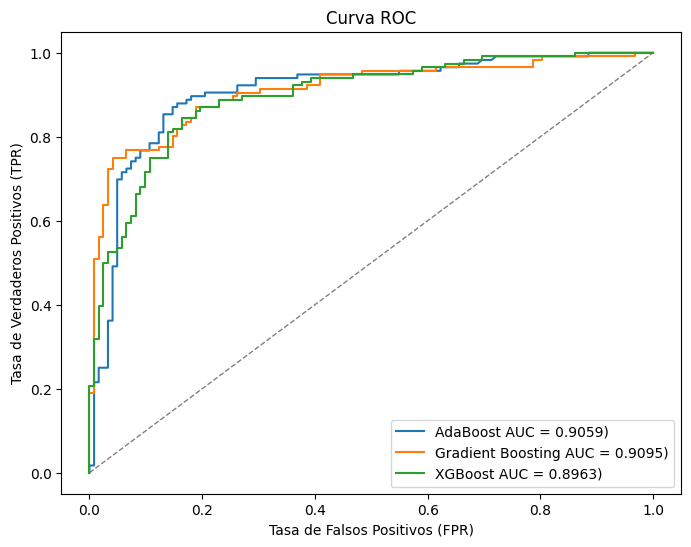

In [123]:
from local_utils import plot_roc

# Listas de modelos y nombres
lst_model = [adaboost_classifier, gradient_boosting_classifier, xgb_classifier]
lst_model_name = ["AdaBoost", "Gradient Boosting", "XGBoost"]

# Visualizar la curva ROC
plot_roc(X_test, y_test, lst_model, lst_model_name)

```
5. Muestra las variables por nivel de importancia para el mejor modelo, luego de la
búsqueda de hiper parámetro. Comenta.
```

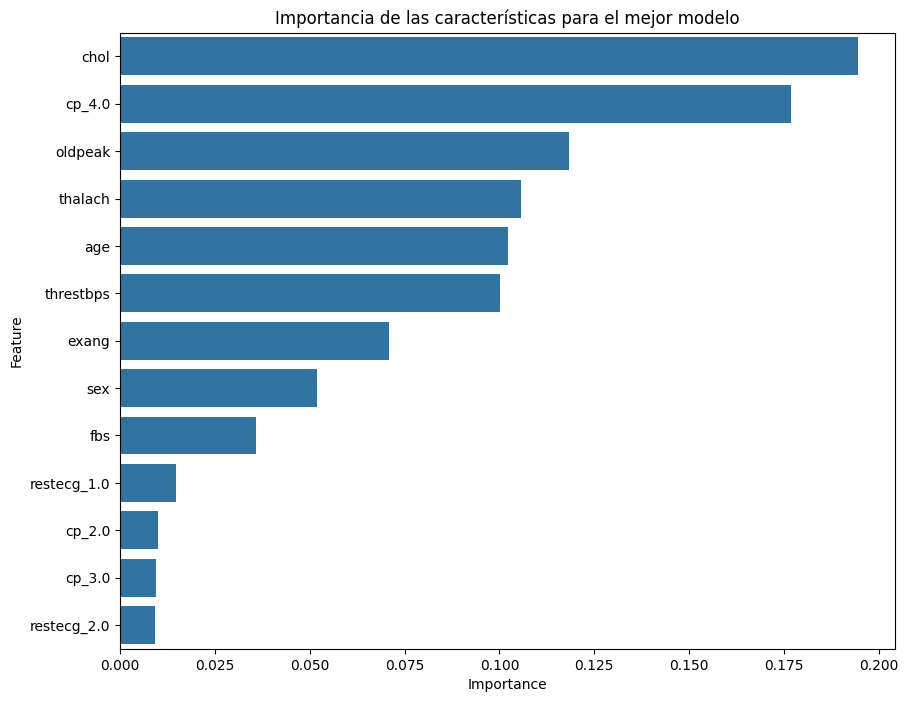

In [124]:
import matplotlib.pyplot as plt

# Obtener la importancia de las características
feature_importances = best_model.feature_importances_
features = X.columns

# Crear un dataframe para la visualización
importance_df = pd.DataFrame({"Feature": features, "Importance": feature_importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Visualizar la importancia de las características
plt.figure(figsize=(10, 8))
sns.barplot(x="Importance", y="Feature", data=importance_df)
plt.title("Importancia de las características para el mejor modelo")
plt.show()

```
Al aplicar features importance podemos ver que tan relavantes son cada una de las variables para la predicción del precio de un producto. 

```